In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import planarity
from networkx.algorithms import community
import collections

In [15]:
raw_data = pd.read_csv('cleaned_data.csv',index_col=0)
raw_data

,简称,日期,开盘价(元),收盘价(元),subsector,month,year,return
601519.SH,大智慧,2011-01-28,8.56,8.72,其他金融业,2011-01,2011,0.018519
601519.SH,大智慧,2011-01-31,8.42,8.23,其他金融业,2011-01,2011,-0.022824
601519.SH,大智慧,2011-02-01,8.21,8.27,其他金融业,2011-02,2011,0.007282
601519.SH,大智慧,2011-02-09,7.90,7.83,其他金融业,2011-02,2011,-0.008900
601519.SH,大智慧,2011-02-10,7.81,8.12,其他金融业,2011-02,2011,0.038925
...,...,...,...,...,...,...,...,...
601377.SH,兴业证券,2021-01-13,9.02,9.02,资本市场服务,2021-01,2021,0.000000
601377.SH,兴业证券,2021-01-14,8.96,8.73,资本市场服务,2021-01,2021,-0.026005
601377.SH,兴业证券,2021-01-15,8.76,8.74,资本市场服务,2021-01,2021,-0.002286
601377.SH,兴业证券,2021-01-18,8.71,8.80,资本市场服务,2021-01,2021,0.010280


In [16]:
name_need = raw_data[raw_data['year']==2010][['简称','subsector']].drop_duplicates()
name_need.set_index(["简称"], inplace=True)
name_need

,subsector
简称,
九鼎投资,其他金融业
东方能源,其他金融业
浙江东方,其他金融业
爱建集团,其他金融业
*ST熊猫,其他金融业
...,...
长江证券,资本市场服务
华鑫股份,资本市场服务
绿庭投资,资本市场服务


In [43]:
years = raw_data['year'].drop_duplicates()
years[0]

2011

In [44]:
# for years
def get_graph_dist(year):
    raw_data = pd.read_csv('cleaned_data.csv',index_col=0)
    one_month = raw_data[raw_data['year']==year]
    pivot_m = pd.pivot_table(data=one_month,values='return',columns='简称',index='日期')
    corr=pivot_m.corr()
    distance_m = pd.DataFrame(np.tril(np.sqrt(2*(1-corr))))
    distance_m.columns=corr.columns
    distance_m.index=corr.columns
    zipped = []
    for i in range(len(distance_m.columns)):
        zipped.append(list(zip([distance_m.columns[i]]*distance_m.shape[0],distance_m.index,distance_m[distance_m.columns[i]])))
    List_flat = []
    for i in zipped:
        for j in i:
            if not np.isnan(j[2]):
                List_flat.append(j)
    s_List_flat = list(set(List_flat))
    # print(len(s_List_flat))
    List = []
    for i in range(len(s_List_flat)):
        # print(s_List_flat[i])
        if float(s_List_flat[i][2])!=0:
            List.append(s_List_flat[i])
    G = nx.Graph()
    node_list = list([x for x,y,z in s_List_flat])
    for i in range(len(node_list)):
        if one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '资本市场服务':
            G.add_node(node_list[i],color ='yellow')
        elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '保险业':
            G.add_node(node_list[i],color ='blue')
        elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '货币金融':
            G.add_node(node_list[i],color ='red')
        elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '其他金融业':
            G.add_node(node_list[i],color ='green')
    G.add_weighted_edges_from(List)
    return G

def sort_graph_edges_dist(G):
    sorted_edges = []
    tmp = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = False)
    for source, dest, data in tmp: # in descending order!
        sorted_edges.append({'source': source,
                            'dest': dest,
                            'weight': data['weight']})
    return sorted_edges

def compute_PMFG(G):
    PMFG = nx.Graph() 
    ne_total = G.number_of_edges()
    nb_nodes = len(G.nodes)
    ne_pmfg = 3*(nb_nodes-2)
    sorted_edges = sort_graph_edges_dist(G)
    t0 = time.time()
    for i, edge in enumerate(sorted_edges):
        PMFG.add_edge(edge['source'], edge['dest'], weight = edge['weight'])
        if not planarity.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
        ne = PMFG.number_of_edges()
        print("Generating PMFG... added edges in PMFG %d/%d (%.2f%%) lookup edges in G %d/%d (%.2f%%) Elapsed TIme %.2f [sec]"            %(ne, ne_pmfg, (ne/ne_pmfg)*100, i, ne_total, (i+1/ne_total)*100, time.time()-t0), end="\r")
        if ne == ne_pmfg:
            break
    return PMFG

def entropy(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print(degree_sequence)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    pros = np.matrix(np.array(cnt))/sum(cnt)

    etp = -pros*np.log(pros).T
    # print(float(etp[0]))
    return float(etp[0])

In [50]:
def save_graph(year):
    raw_data = pd.read_csv('cleaned_data.csv',index_col=0)
    one_month = raw_data[raw_data['year']==year]
    G = get_graph_dist(year)
    pfmg = compute_PMFG(G)
{str(year)}.gpickle')

In [51]:
for i in years:
    save_graph(i)

# entropy

In [52]:
entropy_l_pmfg = []
t0 = time.time()
for i in years:
    # print(i)
    G = get_graph_dist(i)
    pmfg = compute_PMFG(G)
    # nx.write_gpickle(pmfg, f"42_currencies_graph/{i}.gpickle")
    etp = entropy(pmfg)
    entropy_l_pmfg.append(etp)
print('time used: ', time.time()-t0)


time used:  361.8976056575775


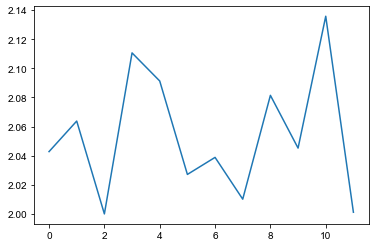

In [53]:
plt.plot(entropy_l_pmfg)

# degree_centrality 

In [95]:
df_degree_centrality = pd.DataFrame(degree_centrality,index=['degree_centrality']).T
# print(df_degree_centrality)

df_degree_centrality = df_degree_centrality.join(name_need, lsuffix='_')
# print(df_degree_centrality.shape)
df_degree_centrality

       degree_centrality
东吴证券            0.155738
申万宏源            0.155738
西安银行            0.049180
青农商行            0.073770
天风证券            0.065574
...                  ...
仁东控股            0.024590
国网英大            0.024590
*ST安信           0.024590
西部资源            0.024590
*ST熊猫           0.024590

[123 rows x 1 columns]


,degree_centrality,subsector
东吴证券,0.155738,资本市场服务
申万宏源,0.155738,资本市场服务
西安银行,0.049180,货币金融
青农商行,0.073770,货币金融
天风证券,0.065574,资本市场服务
...,...,...
仁东控股,0.024590,其他金融业
国网英大,0.024590,其他金融业
*ST安信,0.024590,其他金融业
西部资源,0.024590,货币金融


In [96]:
df_degree_centrality.groupby(by='subsector').mean()

,degree_centrality
subsector,
保险业,0.032787
其他金融业,0.036690
货币金融,0.050231
资本市场服务,0.053425


# betweenness_centrality

In [11]:
between_centrality=nx.betweenness_centrality(pfmg1) 

between_centrality_list= sorted(between_centrality.items(),key=lambda x:x[1],reverse=True)

keys = [k[0] for k in between_centrality_list]
values = [k[1] for k in between_centrality_list]


NameError: name 'pfmg1' is not defined

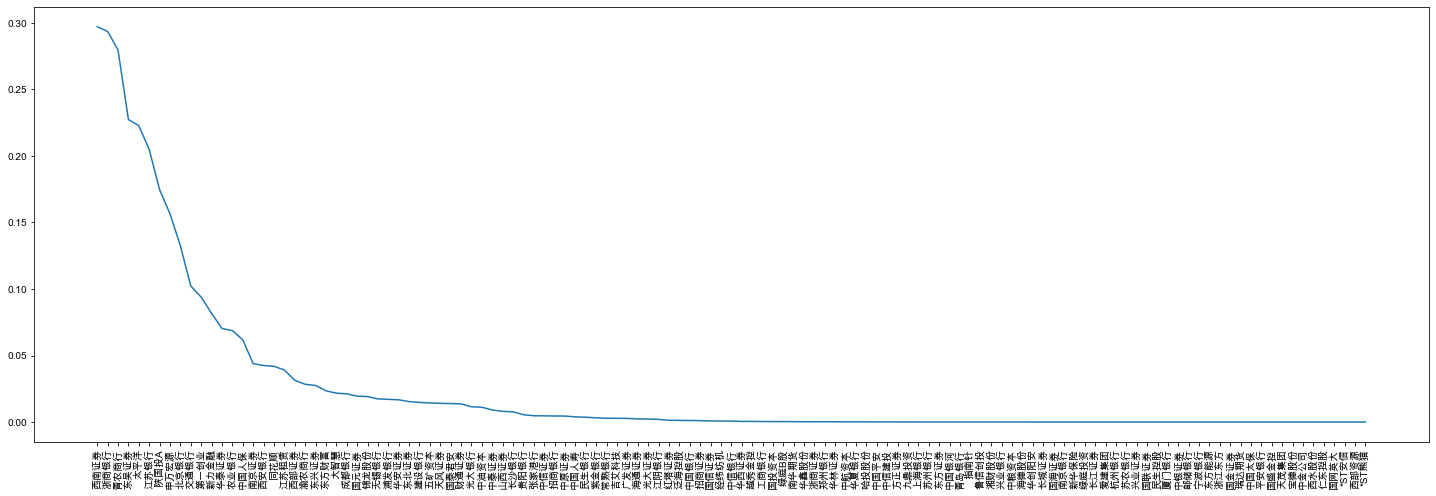

In [26]:
plt.figure(figsize=(25,8))
plt.xticks(rotation=90)
plt.plot(keys,values)

# degree_centrality

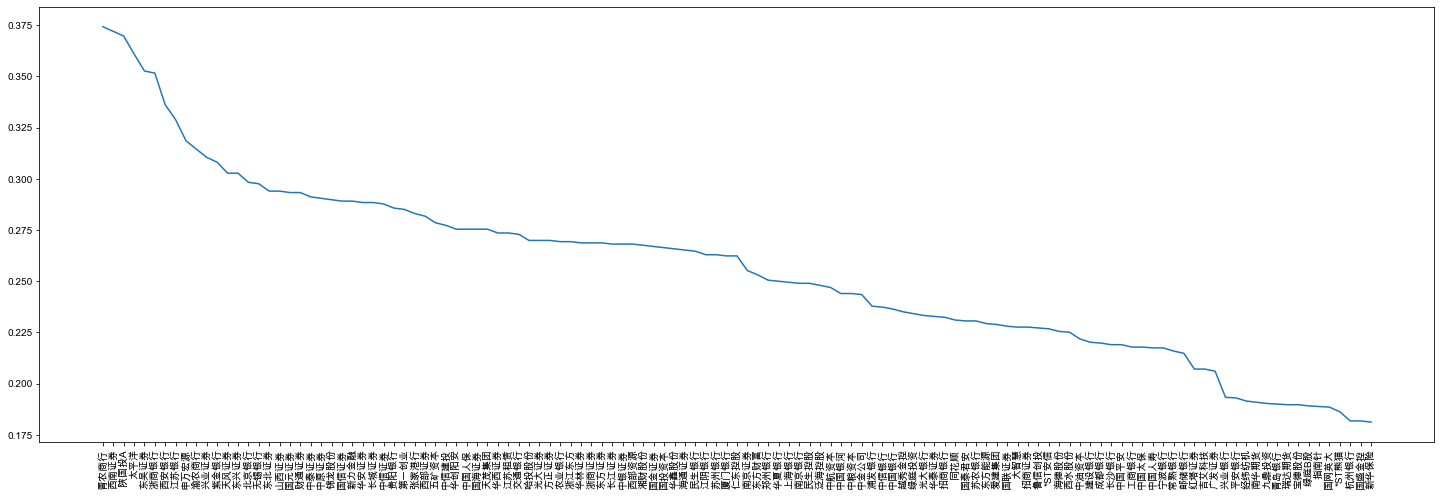

In [27]:
closeness_centrality=nx.degree_centrality(pfmg1) 

closeness_centrality_list= sorted(closeness_centrality.items(),key=lambda x:x[1],reverse=True)

keys = [k[0] for k in closeness_centrality_list]
values = [k[1] for k in closeness_centrality_list]
plt.figure(figsize=(25,8))
plt.xticks(rotation=90)
plt.plot(keys,values)
